Initialisation 

In [101]:
# pip install networkx 
# pip install pyproj

import pandas as pd
import csv
import math
import networkx as nx 
import heapq

# numpy pour dijkstra 
import numpy as np
from numpy import Inf

#Widget
import ipywidgets as widgets
from IPython.display import display

#Map interactive
import folium as f
from folium.plugins import MarkerCluster

#Map pour connection
import matplotlib.pyplot as plt
%matplotlib inline

#Calcul great circle
import pyproj


#import os
#import flightradar24

## Regles de codage 


In [29]:
'''
type_nom_variable
nomFonction(nom_variable : type) 
\'''
    description
    retour :  avec un exemple de forme 
\'''

aeroport ipv airports 
vol --> routesANLO --> df_vols
routes --> dict_routes 

'''

"\ntype_nom_variable\nnomFonction(nom_variable : type) \n'''\n    description\n    retour :  avec un exemple de forme \n'''\n\naeroport ipv airports \nvol --> routesANLO --> df_vols\nroutes --> dict_routes \n\n"

## Importation des données

In [30]:
chemin="../data/"

#df_aeroports = pd.read_csv(chemin + "aeroportsANLO.csv")
#df_zones = pd.read_csv(chemin + "zonesANLO.csv")
df_vols = pd.read_csv(chemin + "routesANLO.csv")
#df_compagnies = pd.read_csv(chemin + "compagniesANLO.csv")

In [31]:
dict_compagnies = {}

with open(chemin+'compagniesANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    next(reader, None)
    headers = ['Name','Country']
    dict_compagnies = {rows[2]:dict(zip(headers,[rows[0],rows[3]])) for rows in reader}


In [32]:
dict_aeroports = {}

with open(chemin+'aeroportsANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_aeroports = {rows[1]:dict(zip(headers,rows[0:8])) for rows in reader}

dict_aeroports['CDG']

{'Name': 'Paris Charles de Gaulle Airport',
 'Iata': 'CDG',
 'Icao': 'LFPG',
 'Lat': '49.012516',
 'Lon': '2.555752',
 'Country': 'France',
 'Alt': '392',
 'City': 'Paris'}

In [33]:
dict_pays = {}

with open(chemin+'countries.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_pays = {rows[1]:rows[0] for rows in reader}

dict_pays

{'Algeria': 'Africa',
 'Angola': 'Africa',
 'Benin': 'Africa',
 'Botswana': 'Africa',
 'Burkina Faso': 'Africa',
 'Burundi': 'Africa',
 'Cameroon': 'Africa',
 'Cape Verde': 'Africa',
 'Central African Republic': 'Africa',
 'Chad': 'Africa',
 'Comoros': 'Africa',
 'Congo': 'Africa',
 'Democratic Republic Of The Congo': 'Africa',
 'Djibouti': 'Africa',
 'Egypt': 'Africa',
 'Equatorial Guinea': 'Africa',
 'Eritrea': 'Africa',
 'Ethiopia': 'Africa',
 'Gabon': 'Africa',
 'Gambia': 'Africa',
 'Ghana': 'Africa',
 'Guinea': 'Africa',
 'Guinea-Bissau': 'Africa',
 "Cote D'ivoire (Ivory Coast)": 'Africa',
 'Kenya': 'Africa',
 'Lesotho': 'Africa',
 'Liberia': 'Africa',
 'Libya': 'Africa',
 'Madagascar': 'Africa',
 'Malawi': 'Africa',
 'Mali': 'Africa',
 'Mauritania': 'Africa',
 'Mauritius': 'Africa',
 'Morocco': 'Africa',
 'Mozambique': 'Africa',
 'Namibia': 'Africa',
 'Niger': 'Africa',
 'Nigeria': 'Africa',
 'Rwanda': 'Africa',
 'Sao Tome And Principe': 'Africa',
 'Senegal': 'Africa',
 'Seychell

In [34]:
df_vols = df_vols[["Depart","Arrivee","Code_ICAO"]].dropna()

In [35]:
#Nettoyage de la df_vols
for _, ligne in df_vols.iterrows():
    if not(ligne.Depart in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Depart'] == ligne.Depart].index, inplace=True)
    
    if not(ligne.Arrivee in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Arrivee'] == ligne.Arrivee].index, inplace=True)

In [36]:
def coordDepuisAeroport(iata : str):
    '''
    Fonction : Recherche les coordonnées GPS d'un aéroport
    Retour : lat : float ,lon : float --> Latitude & longitude de l'aéroport
    '''
    lat = float(dict_aeroports[iata]['Lat'])
    lon = float(dict_aeroports[iata]['Lon'])
    return lat,lon

def DistGrandCercle(lat1 : float, lon1 : float, lat2 : float, lon2 : float):
    #Conversion en radian
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    #Delta des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #Rayon terrestre (en km)
    r = 6367.0

    #Formule d'Haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * r * math.asin(math.sqrt(a))


def DistGrandCercleICAO(icao1 : str, icao2 : str):
    #Récupération des coordonnées des aéroports
    latDep, lonDep = coordDepuisAeroport(icao1)
    latArr, lonArr = coordDepuisAeroport(icao2)

    #On calcule la distance les séparant,                                                     
    return DistGrandCercle(latDep,lonDep,latArr,lonArr)

In [37]:
dict_route = {}

g = df_vols.groupby(['Depart','Arrivee'])
taille_groupe = g.size().items()

for liaison, nbrVols in taille_groupe:
    #Si la liaison est déjà dans le dict, on incrémente le nbr de vols
    if(frozenset(liaison) in dict_route):
        dict_route[frozenset(liaison)]['Vols'] += nbrVols
    #Sinon, on crée une nouvelle liaison
    else:
        dict_route[frozenset(liaison)] = {'Dist' : DistGrandCercleICAO(liaison[0],liaison[1]), 'Vols' : nbrVols}

#Exemple :
dict_route[frozenset(('CDG','SIN'))]

{'Dist': 10717.48589664754, 'Vols': 5}

In [38]:
def filtreDictAeroports(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des aéroports
    '''
    Listtmp = []
    for (key, value) in dict_aeroports.items():
        if value[colonne] == valeur:
            Listtmp.append(key)
    return Listtmp

def filtreDictCompagnies(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des compagnies
    '''
    Listtmp = []
    for (key, value) in dict_compagnies .items():
        if value[colonne] == valeur:
            Listtmp.append(key)
    return Listtmp

# Fonctions -- Correspondance 

In [90]:
def correspondanceAirport(code1 : str, code2 : str):
    '''
    fonction qui filtre le df_vols pour obtenir les correspondances
    retour : list des airports codes 
    '''
    r1 = df_vols[df_vols['Depart'] == code1]['Arrivee'].to_list()
    r2 = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

In [91]:
def creationEdges(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str):
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        et les ajouts dans le graph donne en parametre 
        retour : list des edges ajoute a la graphe [(start , end, weight), (start, end ,weight ) .. ]
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    list_connections = correspondanceAirport(code1, code2)
    # pour gerer les correspondances 
    if list_reference.count(code1) == 0: list_reference.append(code1); 
    if list_reference.count(code2) == 0: list_reference.append(code2)
    
    for i in list_connections :
        if list_reference.count(i) == 0 : 
            list_reference.append(i)     
    
    index1 = list_reference.index(code1) 
    index2 = list_reference.index(code2)
   
    list_edges = list(map(lambda x : (index1, list_reference.index(x), int(DistGrandCercleICAO(code1, x))), list_connections))
    list_edges.extend(list(map(lambda y : (list_reference.index(y), index2, int(DistGrandCercleICAO(y, code2))), list_connections)))
    
    graphe.add_weighted_edges_from(list_edges)
    return list_edges

In [93]:
def dessinerGraphe(graphe):
 
    pos = nx.fruchterman_reingold_layout(graphe)
    nx.draw_networkx_nodes(graphe, pos, node_size = 200)
    nx.draw_networkx_edges(graphe,pos, edgelist= graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(graphe, pos)
    plt.autoscale()
    #plt.title((code1,code2))
    #x.draw_networkx_edge_labels(nom_graphe, pos) # afficher le weight 

    plt.show()

In [95]:
def conversion(list_weighted_edges : list[tuple], graphe : nx.Graph):
    '''
        function qui convertie un list avec les edges d'uin graph avec leur "weight" et 
        qui le convertie en une dict de graph qui peut être utilise par le algorithme de dijkstra 
        retour : le dict qui represente une graphe sous forme de { ind_start : [(end, weight) , (end, weight)], ind_start : [ ..] etc }
    '''
    # calculer le nombre de nodes 
    int_nodes = graphe.number_of_nodes()
    
    # creation d'une dict avec le nombre de nodes initialise avec une liste vide 
    dict_return= dict()
    
    for i in range(0,int_nodes):         
        dict_return[i] = []

    # remplir le dictionairy a partir de listOfEdgesWeighted
    for t in list_weighted_edges:
        # on doit ajoute les edges dans les deux cote (de 1 --> 2 et de 2 --> 1)
        dict_return[t[0]].append((t[1],t[2])) 
        dict_return[t[1]].append((t[0],t[2])) 
        
    return dict_return

In [96]:
def lazyDijkstras(graph, root):
    n = len(graph)
    # set up "inf" distances
    dist = [Inf for _ in range(n)]
    # set up root distance
    dist[root] = 0
    # set up visited node list
    visited = [False for _ in range(n)]
    # set up priority queue
    pq = [(0, root)]
    # while there are nodes to process
    while len(pq) > 0:
        # get the root, discard current distance
        _, u = heapq.heappop(pq)
        # if the node is visited, skip
        if visited[u]:
            continue
        # set the node to visited
        visited[u] = True
        # check the distance and node and distance
        for v, l in graph[u]:
            # if the current node's distance + distance to the node we're visiting
            # is less than the distance of the node we're visiting on file
            # replace that distance and push the node we're visiting into the priority queue
            if dist[u] + l < dist[v]:
                dist[v] = dist[u] + l
                heapq.heappush(pq, (dist[v], v))
    return dist

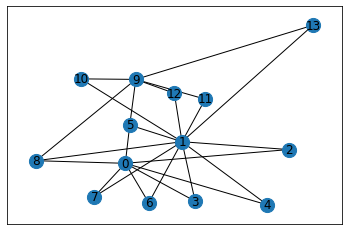

[0, 761, 147, 818, 99, 2456, 1192, 1205, 583, 709, 1318, 2196, 2606, 741]


In [98]:
graph_test4_2 = nx.Graph(); 
ref_test4_2 = []

# creer une correspondance 
test_time2 = creationEdges(graph_test4_2, ref_test4_2, 'AAR', 'DUS')
test_time2.extend(creationEdges(graph_test4_2, ref_test4_2, 'DUS', 'ANR'))

dessinerGraphe(graph_test4_2)
t_dijk = conversion(test_time2, graph_test4_2)

r_dijk = lazyDijkstras(t_dijk, 0)
print(r_dijk)

In [99]:
def returnDistanceAirport(code : str, result_Dijkstra : list[int], list_reference : list[str]):
    index = list_reference.index(code)
    return result_Dijkstra[index]

In [100]:
code = 'ANR'
r_dist = returnDistanceAirport(code, r_dijk, ref_test4_2)
print("le correspondance qui a le moins de distance est {} et c'est le airport {}".format(r_dist, code))

le correspondance qui a le moins de distance est 709 et c'est le airport ANR


Widget StoryLine 